In [1]:
# system tools
import os
import sys
sys.path.append(os.path.join("..", ".."))

# data munging tools
import pandas as pd
import numpy as np
import utils.classifier_utils as clf

# Machine learning stuff
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

# tools from tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, 
                                     Flatten, GlobalMaxPool1D, Conv1D)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import to_categorical

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_history(H, epochs):
    """
    Utility function for plotting model history using matplotlib
    
    H: model history 
    epochs: number of epochs for which the model was trained
    """
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def create_embedding_matrix(filepath, word_index, embedding_dim):
    """ 
    A helper function to read in saved GloVe embeddings and create an embedding matrix
    
    filepath: path to GloVe embedding
    word_index: indices from keras Tokenizer
    embedding_dim: dimensions of keras embedding layer
    """
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [3]:
filename = os.path.join("..", "..", "data", "assignment6", "Game_of_Thrones_Script.csv")

DATA = pd.read_csv(filename)

In [4]:
sentences = DATA["Sentence"].values
labels = DATA["Season"].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(sentences,       # texts for the model
                                                    labels,          # classification labels
                                                    test_size=0.2,   # create an 80/20 split
                                                    random_state=42) # random state for reproducibility

In [6]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [7]:
# initialize tokenizer
tokenizer = Tokenizer(num_words=None)

# fit to training data
tokenizer.fit_on_texts(X_train)

# tokenized training and test data
X_train_toks = tokenizer.texts_to_sequences(X_train)
X_test_toks = tokenizer.texts_to_sequences(X_test)

# overall vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# inspect
print(X_train[1])
print(X_train_toks[1])

Will there be pain?
[27, 66, 21, 920]


In [8]:
# max length for a doc
maxlen = max([len(x) for x in X_train]) #max length of sentences

# pad training data to maxlen
X_train_pad = pad_sequences(X_train_toks, 
                            padding='post', # sequences can be padded "pre" or "post" (post means adding 0s to the end of the sequence)
                            maxlen=maxlen)
# pad testing data to maxlen
X_test_pad = pad_sequences(X_test_toks, 
                           padding='post', 
                           maxlen=maxlen)

In [9]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [11]:
# define embedding size we want to work with
embedding_dim = 50 

embedding_matrix = create_embedding_matrix(os.path.join("..", "..", "data", "assignment6", "glove", "glove.6B.50d.txt"),
                                           tokenizer.word_index, 
                                           embedding_dim)

In [12]:
# initialize Sequential model
model = Sequential()

# add Embedding layer
model.add(Embedding(input_dim=vocab_size,       # vocab size from Tokenizer()
                    output_dim=embedding_dim,   # user defined embedding size
                    input_length=maxlen,        # maxlen of padded docs 
                    weights=[embedding_matrix], # pretrained GloVe weights
                    trainable=False))           # embeddings are static - not trainable

# CONV+ReLU -> MaxPool -> FC+ReLU -> Out
model.add(Conv1D(128, 5, 
                activation='relu'))

## add Flatten layer
#model.add(Flatten())
# MaxPool replaces Flatten layer
model.add(GlobalMaxPool1D())


# Add Dense layer; 10 neurons; ReLU activation
model.add(Dense(48, 
                activation='relu'))

# Add prediction node; 1 node with sigmoid; approximates Logistic Regression
model.add(Dense(8, 
                activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1696, 50)          459050    
_________________________________________________________________
conv1d (Conv1D)              (None, 1692, 128)         32128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 48)                6192      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 392       
Total params: 497,762
Trainable params: 38,712
Non-trainable params: 459,050
_________________________________________________________________


In [13]:
history = model.fit(X_train_pad, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

Training Accuracy: 0.7822
Testing Accuracy:  0.1783


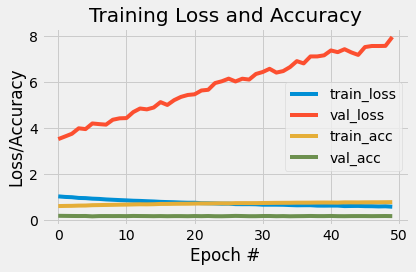

In [14]:
history = model.fit(X_train_pad, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 50)